In [1]:
# import tensorflow as tf

# tf.debugging.set_log_device_placement(True)

# a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
# b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
# c = tf.matmul(a, b)  # Matrix multiplication
# print(c)


In [2]:
# tf.debugging.set_log_device_placement(False)

In [3]:
# !pip install "numpy<2"

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from lxml import etree
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout, Dense

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

/Users/soet-cse-macpc-026/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
# Define paths
train_data_folder = "train"
test_data_folder = "test"

classes = ['With Helmet', 'Without Helmet']

In [6]:
def parse_annotation(annotation_file):
    tree = etree.parse(annotation_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [
            int(bbox.find('xmin').text), int(bbox.find('ymin').text),
            int(bbox.find('xmax').text), int(bbox.find('ymax').text)
        ]
        objects.append(obj_struct)
    return objects

In [7]:
def load_data(data_folder):
    X, y = [], []
    count = 0  # Debug counter

    for file in os.listdir(data_folder):
        if file.endswith('.xml'):  # Annotation file
            annotation_path = os.path.join(data_folder, file)
            objects = parse_annotation(annotation_path)
            
            # Find corresponding image (JPG format)
            image_file = file.replace('.xml', '.jpg')
            image_path = os.path.join(data_folder, image_file)

            if os.path.exists(image_path):
                image = load_img(image_path, target_size=(224, 224))
                image = img_to_array(image)
                X.append(preprocess_input(image))
                
                labels = [0] * len(classes)
                for obj in objects:
                    label_idx = classes.index(obj['name'])
                    labels[label_idx] = 1
                y.append(labels)

                count += 1  # Count successfully loaded images
            else:
                print(f"⚠️ Image file not found for: {file}")

    print(f"✅ Loaded {count} samples from {data_folder}")  # Debug print
    return np.array(X), np.array(y)


In [8]:
X_train, y_train = load_data(train_data_folder)
X_test, y_test = load_data(test_data_folder)

print("Train Data Shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

✅ Loaded 3546 samples from train
✅ Loaded 63 samples from test
Train Data Shape: (3546, 224, 224, 3) (3546, 2)
Test Data Shape: (63, 224, 224, 3) (63, 2)


In [9]:
# # Split data into training and testing sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test(X_train, y_train, test_size=0.2, random_state=42)

# # Check the shapes of the split data
# print("Training data shape:", X_train.shape)
# print("Testing data shape:", X_test.shape)
# print("Training labels shape:", y_train.shape)
# print("Testing labels shape:", y_test.shape)

In [10]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input
# from tensorflow.keras.regularizers import l2

# # Load pre-trained ResNet50 without top layers
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Fine-tune only the last 50% of ResNet50 layers
# for layer in base_model.layers[:80]:  
#     layer.trainable = False  # Freeze first 80 layers
# for layer in base_model.layers[80:]:  
#     layer.trainable = True   # Unfreeze last layers for fine-tuning

# # Custom layers added on top of ResNet50
# x = base_model.output
# x = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = GlobalAveragePooling2D()(x)  # Reduce dimensions

# x = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)

# x = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# # Output layer (Binary classification: Helmet/No Helmet)
# output = Dense(1, activation='sigmoid')(x)

# # Define model
# model_resnet50 = Model(inputs=base_model.input, outputs=output)

# # Compile model
# model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model summary
# model_resnet50.summary()


In [11]:
# Load pre-trained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune only the last 50% of ResNet50 layers
for layer in base_model.layers[:80]:  
    layer.trainable = False
for layer in base_model.layers[80:]:  
    layer.trainable = True  

# Custom layers on top of ResNet50
x = base_model.output
x = Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)  # Reduce dimensions

x = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer (Binary classification: 1 neuron with sigmoid)
output = Dense(1, activation='sigmoid')(x)  

# Define model
model_resnet50 = Model(inputs=base_model.input, outputs=output)

# Compile model with Binary Crossentropy
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert labels from one-hot to binary (0 or 1)
y_train = np.argmax(y_train, axis=1)  # Convert from (None, 2) → (None,)
y_test = np.argmax(y_test, axis=1)

# # Model summary
model_resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 48,668,801 (185.66 MB)

 Trainable params: 47,160,321 (179.90 MB)

 Non-trainable params: 1,508,480 (5.75 MB)

# import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable GPU and mixed precision
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

mixed_precision.set_global_policy('mixed_float16')

# Train the model
history = model_resnet50.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

# from tensorflow.keras.callbacks import EarlyStopping

# early_stopper = EarlyStopping(
#     monitor='val_accuracy',   # Monitor validation accuracy
#     patience=5,               # Stop if val_accuracy doesn't improve for 5 epochs
#     mode='max',               # 'max' because we want accuracy to increase
#     restore_best_weights=True,# Restore best weights to avoid overfitting
#     verbose=1
# )

# history = model_resnet50.fit(
#     X_train, y_train, 
#     epochs=100, 
#     batch_size=16, 
#     validation_data=(X_test, y_test), 
#     verbose=1,
#     callbacks=[early_stopper]
# )


In [13]:
model_resnet50.save("helmet3_detector_model_2.h5")

In [14]:
# import tensorflow as tf
# from tensorflow.keras import mixed_precision

# # Enable GPU and mixed precision
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

# mixed_precision.set_global_policy('mixed_float16')

# # Train the model
# hist = model_resnet50.fit(
#     X_train, y_train, 
#     epochs=50, 
#     batch_size=16, 
#     validation_data=(X_test, y_test), 
#     verbose=1
# )


In [15]:
test_loss, test_acc = model_resnet50.evaluate(X_test, y_test, batch_size=8, verbose=2)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

8/8 - 4s - 481ms/step - accuracy: 0.7302 - loss: 1.4240
Test Loss: 1.4239981174468994
Test Accuracy: 0.7301587462425232


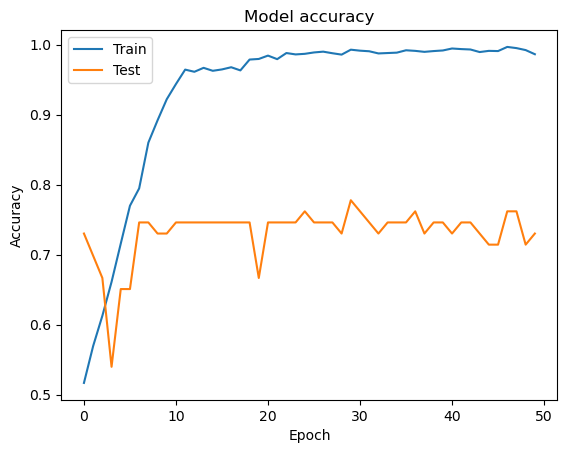

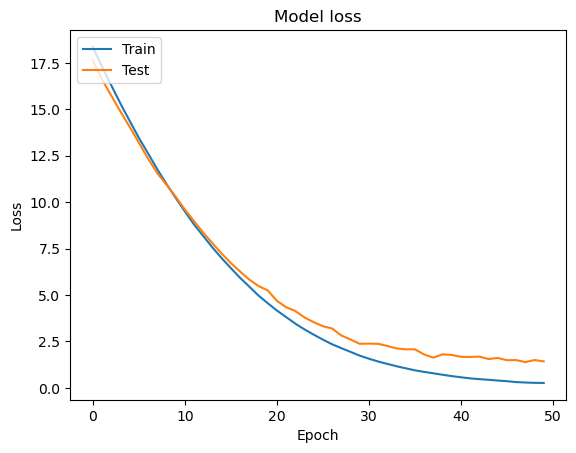

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# Predict probabilities
y_pred_probs = model_resnet50.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [18]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84        47
           1       0.00      0.00      0.00        16

    accuracy                           0.73        63
   macro avg       0.37      0.49      0.42        63
weighted avg       0.55      0.73      0.63        63

Accuracy: 0.7301587301587301


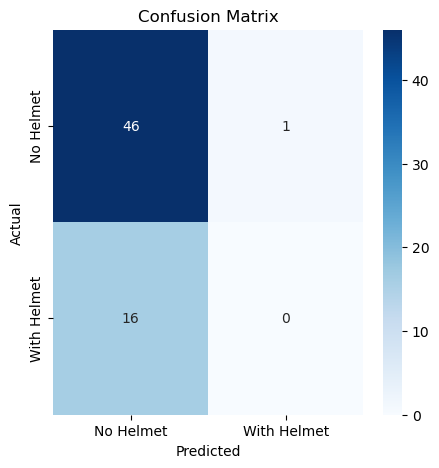

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Helmet", "With Helmet"], yticklabels=["No Helmet", "With Helmet"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [20]:
# import cv2
# import numpy as np

# # Define labels
# class_labels = ["No Helmet", "With Helmet"]

# # Open webcam
# cap = cv2.VideoCapture(0)  # Use 0 for default webcam

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Preprocess frame
#     img = cv2.resize(frame, (224, 224))  
#     img = img / 255.0  # Normalize
#     img = np.expand_dims(img, axis=0)  # Add batch dimension

#     # Predict
#     pred = model_resnet50.predict(img)

#     if pred.shape[-1] == 2:  # If using softmax
#         predicted_class = np.argmax(pred, axis=1)[0]
#     else:  # If using sigmoid (binary classification)
#         predicted_class = 1 if pred[0][0] > 0.5 else 0

#     # Display result
#     label = class_labels[predicted_class]
#     color = (0, 255, 0) if label == "With Helmet" else (0, 0, 255)
#     cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

#     cv2.imshow("Helmet Detection", frame)

#     # Press 'q' to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


In [21]:
# import cv2
# import numpy as np
# from tensorflow.keras.preprocessing import image

# # Load the image
# img_path = "C://Users//HP//OneDrive//Pictures//Screenshots//Screenshot 2025-03-18 090112.png"  # Change this to your image path
# img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size

# # Convert image to array and preprocess
# img_array = image.img_to_array(img) / 255.0  # Normalize
# img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch

# # Predict using the trained model
# pred = model_resnet50.predict(img_array)

# # Check the prediction output
# print("Raw Prediction:", pred)

# # Interpret the result
# if pred.shape[-1] == 1:  # Binary classification
#     predicted_class = "With Helmet" if pred[0][0] > 0.5 else "Without Helmet"
# else:  # Multi-class classification (Softmax)
#     class_labels = ["Without Helmet", "With Helmet"]
#     predicted_class = class_labels[np.argmax(pred)]

# print(f"Predicted Class: {predicted_class}")


In [22]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("D://Downloads//Helmet//helmet_detector_model.h5")  # Update the path

# Load and preprocess the image
image_path = "C://Users//HP//OneDrive//Pictures//Screenshots//Screenshot 2025-03-18 090112.png"  # Update with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))  # Resize to match model's input size
image = image / 255.0  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make a prediction
prediction = model.predict(image)

# Display the result
plt.imshow(cv2.imread(image_path)[:, :, ::-1])
plt.axis("off")

# Assuming binary classification (Helmet / No Helmet)
if prediction[0][0] > 0.5:
    plt.title("Helmet Detected")
else:
    plt.title("No Helmet Detected")

plt.show()


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# import tensorflow as tf
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt

# Load the trained model
#model = tf.keras.models.load_model("D://Downloads//Helmet//helmet_detector_model.h5")  # Update the path

# Load and preprocess the image
image_path = "C://Users//HP//OneDrive//Pictures//Screenshots//Screenshot 2025-03-15 223638.png"  # Update with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))  # Resize to match model's input size
image = image / 255.0  # Normalize pixel values
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make a prediction
prediction = model.predict(image)

# Display the result
plt.imshow(cv2.imread(image_path)[:, :, ::-1])
plt.axis("off")
print(prediction[0][0])
# Assuming binary classification (Helmet / No Helmet)
if prediction[0][0] > 0.5:
    plt.title("Helmet Detected")
else:
    plt.title("No Helmet Detected")

plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to plot count distribution
# def plot_class_distribution(y_data, title):
#     # Convert y_data from one-hot encoding to class counts
#     class_counts = np.sum(y_data, axis=0)
    
#     # Define class labels (update based on your dataset)
#     class_labels = ["No Helmet", "Helmet"]
    
#     # Create a DataFrame
#     df = pd.DataFrame({"Class": class_labels, "Count": class_counts})
    
#     # Plot using Seaborn
#     plt.figure(figsize=(6, 4))
#     sns.barplot(x="Class", y="Count", data=df, palette="viridis")
#     plt.title(title)
#     plt.xlabel("Class")
#     plt.ylabel("Count")
#     plt.show()
    

# # Plot distribution for training and testing sets
# plot_class_distribution(y_train, "Training Data Distribution")
# plot_class_distribution(y_test, "Testing Data Distribution")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot count distribution dynamically
def plot_class_distribution(y_data, title):
    # Sum over axis 0 to get class-wise counts
    class_counts = np.sum(y_data, axis=0)

    # Extract class labels dynamically
    class_labels = [f"Class {i}" for i in range(len(class_counts))]

    # Create a DataFrame
    df = pd.DataFrame({"Class": class_labels, "Count": class_counts})

    # Plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Class", y="Count", data=df, palette="viridis")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Plot distributions for training and testing sets
plot_class_distribution(y_train, "Training Data Distribution")
plot_class_distribution(y_test, "Testing Data Distribution")


In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test(X_train, y_train, test_size=0.2, random_state=42)

# Check the shapes of the split data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)